## Imports

In [ ]:
import random
import pickle
import string
from itertools import product
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import torch

from transformer_lens import HookedTransformer
from transformer_lens import utils, patching

from IPython.display import clear_output

from string import ascii_uppercase
from tqdm import tqdm
import random
import pickle

import pandas as pd
import matplotlib.pyplot as plt

import torch
import pickle

from sentence_transformers.util import semantic_search, dot_score, normalize_embeddings
from transformer_lens import HookedTransformer
from src.org_paper.adv_gen import *
from src.utils.plotly_utils import imshow, line, scatter

torch.manual_seed(42)
data_path = "/content/drive/MyDrive/Uva/data/"

## Adversarial sample generations

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

In [ ]:
# tokens of capital letters
cap_tokens = model.to_tokens([x for x in ascii_uppercase], prepend_bos=False)[:, 0]
cap_tokens_space = model.to_tokens([" " + str(x) for x in ascii_uppercase], prepend_bos=False)[:, 0]
# as we are taking a subset of the vocabulary, we also enumerate them in order
# (e.g 'A' is the token 32, but is enumerated as 0 on the subspace, etc.)
idx_to_token = {k:v.item() for k, v in enumerate(cap_tokens)}
token_to_idx = {v.item():k for k, v in enumerate(cap_tokens)}
space_to_no_space = {k.item():v.item() for k,v in zip(cap_tokens_space, cap_tokens)}
no_space_to_space = {k.item():v.item() for k,v in zip(cap_tokens, cap_tokens_space)}

In [ ]:
# indices of the token containing the first/second/third capital letters
indices_letters = [2, 3, 4]
# same for the acronym letter -1 (this is where the corresponding logit is stored)
indices_logits = [5, 6, 7]
# letter that we want to modify: 0, 1 or 2
letter = 2

In [ ]:
with open(f"{data_path}/acronyms.txt", "r") as f:
   prompts, acronyms = list(zip(*[line.split(", ") for line in f.read().splitlines()]))

# take a subset of the dataset (we do this because VRAM limitations)
n_samples = 1000

prompts, acronyms = list(map(list, zip(*random.choices(list(zip(prompts, acronyms)), k=n_samples))))

tokens = model.to_tokens(prompts)
# ground truth: third letter of the acronym (tokens)
y = model.to_tokens([x[letter] for x in acronyms], prepend_bos=False).squeeze()
with torch.no_grad():
    y_pred = model(tokens)[:, indices_logits[letter]].argmax(dim=-1)
# discard already misclassified samples
tokens = tokens[y_pred == y]
y = y[y_pred == y]
# reupdate n_samples
n_samples = tokens.shape[0]

y_idx = y.cpu().apply_(token_to_idx.get).cuda()

In [ ]:
full_masked_maxs = []
full_unmasked_maxs = []

full_masked_means = []
full_unmasked_means = []

In [ ]:
for seed in [42,2,3]:

    torch.manual_seed(seed)

    batch_size = 128

    # randomly sample batch_size initial samples
    idx = torch.randint(0, n_samples, (batch_size,))
    sample_tokens = tokens[idx]
    sample_y = y[idx]
    sample_y_idx = y_idx[idx]
    sample_embeddings = model.W_E[sample_tokens].clone().detach()
    sample_embeddings.requires_grad = True

    embedding_matrix = model.W_E

    # now the vocabulary of optimization is every single token word possible
    with open(f"{data_path}/words_dict.pkl", 'rb') as f:
        words_dict = pickle.load(f)
    word_list = [v for _, v in words_dict.items()]
    word_list = [x for xs in word_list for x in xs]
    vocab = model.to_tokens(word_list, prepend_bos=False)[:, 0]

    mask = torch.zeros(sample_tokens.shape[-1], dtype=torch.bool).cuda()
    mask[indices_letters[letter]] = 1

    lr=1e-1
    weight_decay=1e-1
    margin = 4
    loss_fn = AdvMarginLoss(margin=margin)

    gradients = []

    input_optimizer = torch.optim.AdamW([sample_embeddings], lr=lr, weight_decay=weight_decay)

    # we will collect the adversarial samples: samples that are incorrectly classified by the model
    adv_samples = []
    # we also collect the original sample associated to each adversarial sample
    original_samples = []
    losses = []
    # OPTIMIZE
    for _ in tqdm(range(200), disable=False):

        # Project the embeddings
        projected_tokens, projected_embeddings = project_embeddings(sample_tokens,sample_embeddings, embedding_matrix, vocab, mask)
        # BRUH this is causing a high bottleneck. Optimize when everything works right
        sample_y_idx = torch.tensor([token_to_idx[model.to_tokens(model.to_string(x[indices_letters[letter]])[1], prepend_bos=False).item()] for x in projected_tokens], dtype=torch.long).cuda()

        tmp_embeddings = sample_embeddings.detach().clone()
        tmp_embeddings.data = projected_embeddings.data
        tmp_embeddings.requires_grad = True

        # Take the logits of the subspace
        logits_vocab = model.forward(tmp_embeddings + model.pos_embed(projected_tokens), start_at_layer=0)[:, indices_logits[letter], cap_tokens]

        loss = loss_fn(logits_vocab, sample_y_idx, average=True)

        sample_embeddings.grad, = torch.autograd.grad(loss, [tmp_embeddings])
        # set the gradient of elements outside the mask to zero
        gradients.append(sample_embeddings.grad)

        sample_embeddings.grad = torch.where(mask[None, ..., None], sample_embeddings.grad, 0.)
        input_optimizer.step()
        input_optimizer.zero_grad()
        #print(loss.item())
        #print(model.to_string(projected_tokens))
        losses.append(loss.item())

        with torch.no_grad():
            # Re-project the embeddings
            projected_tokens, projected_embeddings = project_embeddings(sample_tokens,sample_embeddings, embedding_matrix, vocab, mask)
            sample_y_idx = torch.tensor([token_to_idx[model.to_tokens(model.to_string(x[indices_letters[letter]])[1], prepend_bos=False).item()] for x in projected_tokens], dtype=torch.long).cuda()
            # check if there are adversarial samples
            # Take the logits of the subspace
            logits_vocab = model.forward(projected_embeddings + model.pos_embed(projected_tokens), start_at_layer=0)[:, indices_logits[letter], cap_tokens]

            loss_i = loss_fn(logits_vocab, sample_y_idx, average=False)
            adv_samples.append(projected_tokens[loss_i < margin]) # a loss lower than margin implies that the sample is incorrectly classified
            original_samples.append(sample_tokens[loss_i < margin])

    adv_samples = torch.cat(adv_samples, dim=0)
    original_samples = torch.cat(original_samples, dim=0)
    adv_samples, inverse_indices = torch.unique(adv_samples, sorted=False, dim=0, return_inverse=True)
    original_samples_unique = torch.zeros_like(adv_samples)
    original_samples_unique[inverse_indices] = original_samples[torch.arange(0, original_samples.shape[0])]
    original_samples = original_samples_unique

    masked_maxs, unmasked_maxs, masked_means, unmasked_means = grad_stat_org(mask, gradients)

    full_masked_maxs.append(masked_maxs)
    full_unmasked_maxs.append(unmasked_maxs)

    full_masked_means.append(masked_means)
    full_unmasked_means.append(unmasked_means)



100%|██████████| 200/200 [01:19<00:00,  2.53it/s]


## Save results

In [ ]:
lists_to_save = [full_masked_maxs,full_unmasked_maxs,full_masked_means,full_unmasked_means]
names = ['full_masked_maxs','full_unmasked_maxs','full_masked_means','full_unmasked_means']

for name, list_to_save in zip(names,lists_to_save):
  
  with open(f'work/saved/acronym/{name}.pickle', 'wb') as handle:
      pickle.dump(list_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Plots

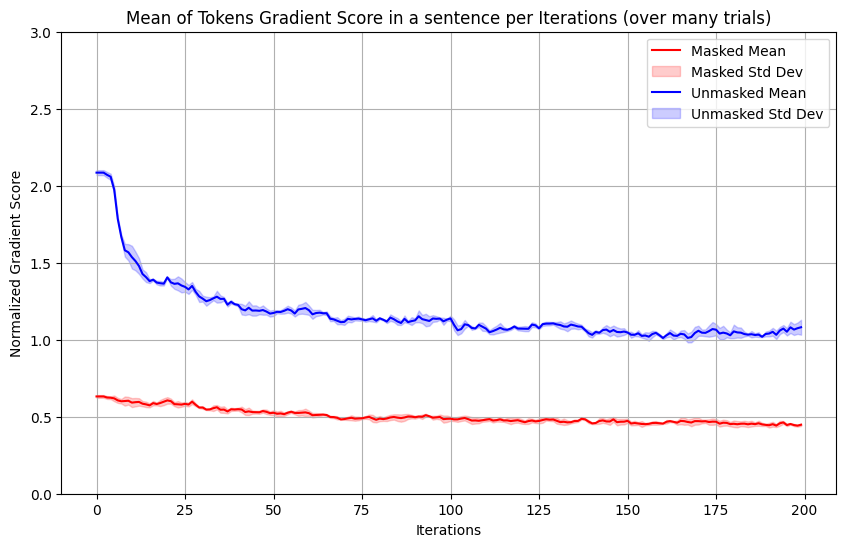

In [ ]:
full_masked_mean = np.array(full_masked_means)
full_unmasked_mean = np.array(full_unmasked_means)

# Compute mean and standard deviation over trials (axis 0)
masked_mean = np.mean(full_masked_mean, axis=0)
masked_std = np.std(full_masked_mean, axis=0)

unmasked_mean = np.mean(full_unmasked_mean, axis=0)
unmasked_std = np.std(full_unmasked_mean, axis=0)

# Plotting
plt.figure(figsize=(10, 6))

# Masked plot with mean and std
plt.plot(range(full_masked_mean.shape[1]), masked_mean, label="Masked Mean", color="red")
plt.fill_between(
    range(full_masked_mean.shape[1]),
    masked_mean - masked_std,
    masked_mean + masked_std,
    color="red",
    alpha=0.2,
    label="Masked Std Dev"
)

# Unmasked plot with mean and std
plt.plot(range(full_unmasked_mean.shape[1]), unmasked_mean, label="Unmasked Mean", color="blue")
plt.fill_between(
    range(full_unmasked_mean.shape[1]),
    unmasked_mean - unmasked_std,
    unmasked_mean + unmasked_std,
    color="blue",
    alpha=0.2,
    label="Unmasked Std Dev"
)

ax = plt.gca()
ax.set_ylim([0, 3])

# Add labels, title, and legend
plt.xlabel("Iterations")
plt.ylabel("Normalized Gradient Score")
plt.title("Mean of Tokens Gradient Score in a sentence per Iterations (over many trials)")
plt.legend()
plt.grid()
plt.show()

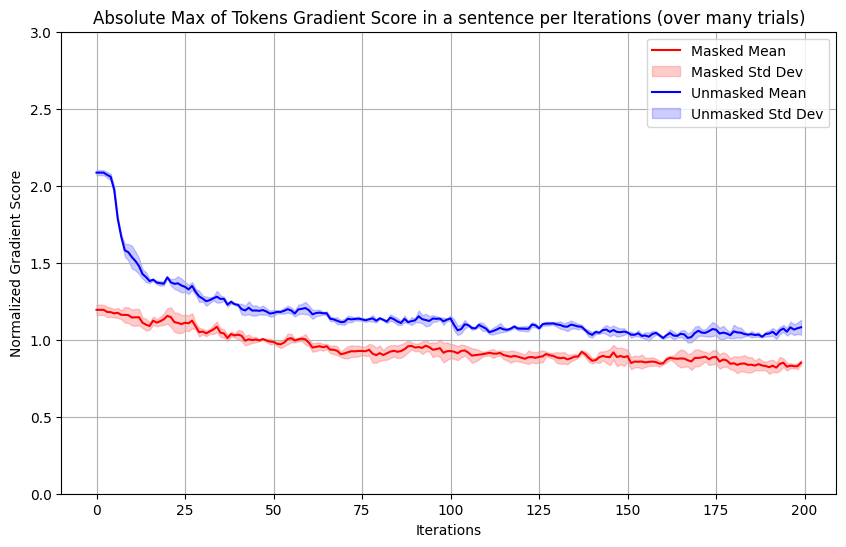

In [ ]:
full_masked_maxs_np = np.array(full_masked_maxs)
full_unmasked_maxs_np = np.array(full_unmasked_maxs)

# Compute mean and standard deviation over trials (axis 0)
masked_mean = np.mean(full_masked_maxs_np, axis=0)
masked_std = np.std(full_masked_maxs_np, axis=0)

unmasked_mean = np.mean(full_unmasked_maxs_np, axis=0)
unmasked_std = np.std(full_unmasked_maxs_np, axis=0)

# Plotting
plt.figure(figsize=(10, 6))

# Masked plot with mean and std
plt.plot(range(full_masked_maxs_np.shape[1]), masked_mean, label="Masked Mean", color="red")
plt.fill_between(
    range(full_masked_maxs_np.shape[1]),
    masked_mean - masked_std,
    masked_mean + masked_std,
    color="red",
    alpha=0.2,
    label="Masked Std Dev"
)

# Unmasked plot with mean and std
plt.plot(range(full_unmasked_maxs_np.shape[1]), unmasked_mean, label="Unmasked Mean", color="blue")
plt.fill_between(
    range(full_unmasked_maxs_np.shape[1]),
    unmasked_mean - unmasked_std,
    unmasked_mean + unmasked_std,
    color="blue",
    alpha=0.2,
    label="Unmasked Std Dev"
)

ax = plt.gca()
ax.set_ylim([0, 3])

# Add labels, title, and legend
plt.xlabel("Iterations")
plt.ylabel("Normalized Gradient Score")
plt.title("Absolute Max of Tokens Gradient Score in a sentence per Iterations (over many trials)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
all_gradients = np.concatenate(
    [np.array(grad.cpu()).reshape(-1, grad.shape[-1]) for grad in gradients], axis=0
)  # Shape: [total_elements, embedding_dim]

global_mean = np.mean(all_gradients, axis=0, keepdims=True)  # Shape: [1, embedding_dim]
global_std = np.std(all_gradients, axis=0, keepdims=True) + 1e-8  # Shape: [1, embedding_dim]

emb_score = []

for it in range(len(gradients)):
    grad = np.array(gradients[it].cpu())  
    # Normalize gradients globally
    grad_norm = (grad - global_mean) / global_std  # Shape: [batch_size, token_length, embedding_dim]

    # Mean over embeddings for each token across the batch
    grad_mean_per_token = np.mean(abs(grad_norm), axis=(2))  # Shape: [batch_size,token_length]

    emb_score.append(grad_mean_per_token)

emb_score = np.array(emb_score)

emb_score_mean_iter = np.mean(emb_score, axis=(0))  # Shape: [batch,token_length]

In [ ]:
with open('work/saved/acronym/emb_score_mean_iter_seed_3_acronym.pickle', 'wb') as handle:
    pickle.dump(emb_score_mean_iter, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('work/saved/acronym/sample_tokens_seed_3_acronym.pickle', 'wb') as handle:
    pickle.dump(sample_tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)

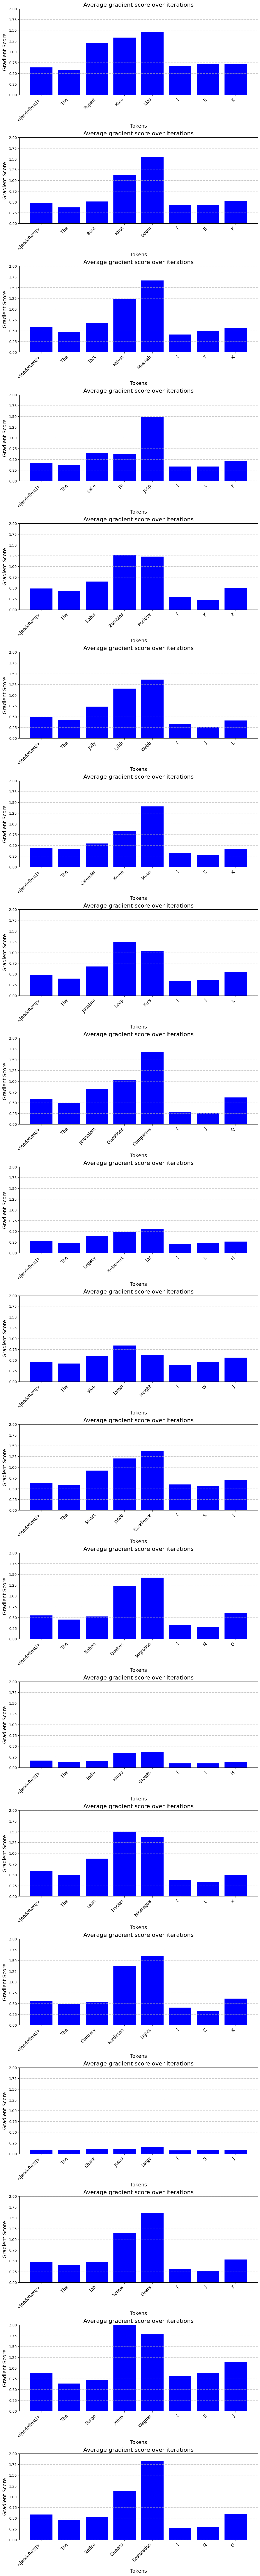

In [ ]:
tokens = sample_tokens[:20]
gradients = emb_score_mean_iter[:20]

decoded_samples = [model.to_string(sample) for sample in tokens]

with open('work/saved/acronym/decoded_samples_seed_3_acronym.pickle', 'wb') as handle:
    pickle.dump(decoded_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plotting
num_samples = len(decoded_samples)
fig, axes = plt.subplots(num_samples, 1, figsize=(10, 5 * num_samples), constrained_layout=True)

for i, (words, grads) in enumerate(zip(decoded_samples, gradients)):
    ax = axes[i]
    ax.bar(range(len(words)), grads, color='blue')
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize=12)
    ax.set_title(f'Average gradient score over iterations', fontsize=16)
    ax.set_ylabel('Gradient Score', fontsize=14)
    ax.set_xlabel('Tokens', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim([0, 2])

# Show the plot
plt.show()